In [1]:
import numpy as np
from fish.ephys import ephys
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import collections
from skimage import io
from scipy.stats import zscore
from numpy import convolve
from scipy.signal import gaussian
import os
%matplotlib inline

In [2]:
exp_dir = '/groups/ahrens/ahrenslab/davis/data/ephys/20161101/'
proc_dir = exp_dir + 'proc/'
if not os.path.exists(proc_dir):
    os.makedirs(proc_dir)

In [3]:
fnames_ep = glob(exp_dir + '*opto*.10chFlt')
fnames_ep.sort()
for ind, f in enumerate(fnames_ep):
    print('{0} : {1}'.format(ind, f))

0 : /groups/ahrens/ahrenslab/davis/data/ephys/20161101/6dpf_cy252xcy293_g1_f1_omr_opto_1.10chFlt
1 : /groups/ahrens/ahrenslab/davis/data/ephys/20161101/6dpf_cy252xcy293_g1_f1_omr_opto_2.10chFlt
2 : /groups/ahrens/ahrenslab/davis/data/ephys/20161101/6dpf_cy252xcy293_g1_f2_omr_opto_1.10chFlt
3 : /groups/ahrens/ahrenslab/davis/data/ephys/20161101/6dpf_cy252xcy293_g1_f2_omr_opto_2.10chFlt
4 : /groups/ahrens/ahrenslab/davis/data/ephys/20161101/6dpf_cy252xcy293_g1_f2_omr_opto_3.10chFlt


In [5]:
exps = np.arange(len(fnames_ep))
exp_names = [fnames_ep[e].split('/')[-1].split('.')[0] for e in exps]

fnames_roi = []
for expn in exp_names:
    fnames_roi.append(glob(exp_dir + expn + '*_ROI_*.tif'))
[f.sort() for f in fnames_roi]
ims_roi = []
for froi in fnames_roi:
    ims_roi.append([plt.imread(f) for f in froi])
dats = [ephys.load(fnames_ep[e]) for e in exps]
ims_anat = [plt.imread(fnames_ep[e].split('.')[0] + '.tif') for e in exps]

In [6]:
cur_exp = 2
exp_name = exp_names[cur_exp]
dat = ephys.load(fnames_ep[cur_exp])
im_roi = np.array(ims_roi[cur_exp])
# add alpha values
im_roi[:,:,:,-1] = im_roi[:,:,:,0]
im_anat = ims_anat[cur_exp]

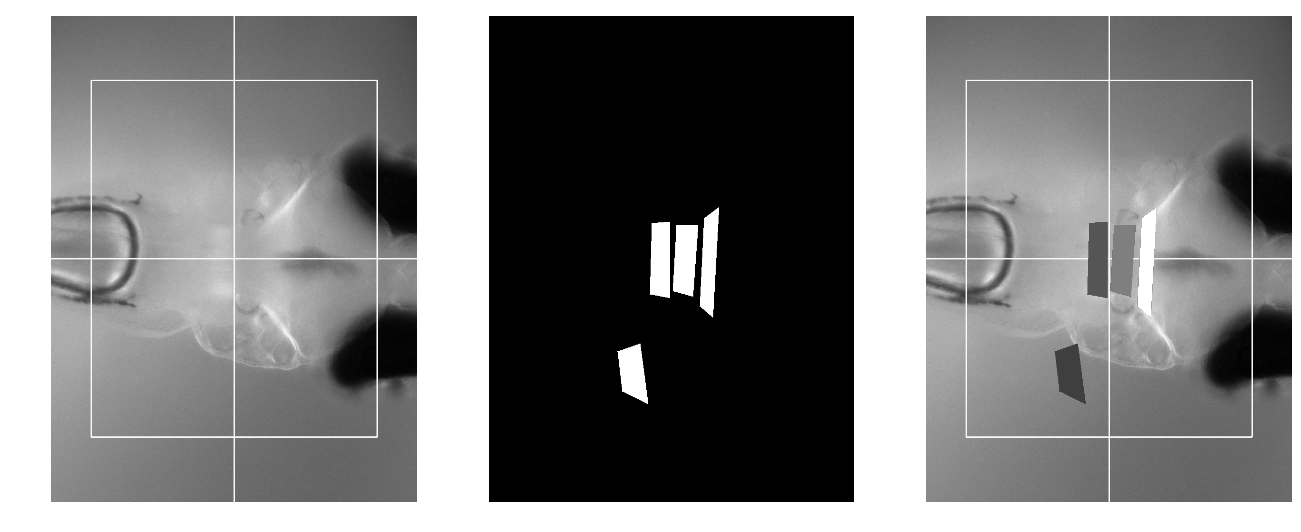

In [7]:
fig, axs = plt.subplots(ncols=3, figsize=(16,16))
axs[0].imshow(im_anat, cmap='gray')
axs[1].imshow(im_roi[:,:,:,:-1].max(0), cmap='gray')

axs[2].imshow(im_anat, cmap='gray')
for ind, r in enumerate(im_roi):
    tmp = r.copy()
    tmp[:,:,:-1] //= (1 + ind)
    axs[2].imshow(tmp, cmap='gray')
    
[a.axis('off') for a in axs];
plt.savefig(proc_dir + exp_name + '_roi_overlay.pdf')

In [8]:
laser = ephys.chopTrials(dat[6])
on_val = max(list(laser.keys()))
rois = ephys.chopTrials(dat[3])
fs = 6000
tr_len = np.median(np.diff(laser[1][0]) / fs)
stim_len = np.ceil(np.median((laser[2][1] - laser[2][0]) / fs))
# for each trial, get the swim power before, during, and after the laser stimulation 
conds = np.arange(1,len(rois))
roi_keys = [x for x in rois]
print('Trial length: {0} s'.format(tr_len))
print('Stim length: {0} s'.format(stim_len))

Trial length: 30.0 s
Stim length: 10.0 s


In [70]:
def ipr(ts, p1=25, p2=99):
    from numpy import percentile, diff
    return diff(percentile(ts, [p1, p2])) 


def filt(v, cutoff, btype='low'):
    from scipy.signal import bessel, filtfilt
    b, a = bessel(4, cutoff, btype=btype)
    return filtfilt(b,a,v)


def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    
def jitter_plot(axis, vec, mean=0, stdev=1, color='k'):
    from numpy.random import randn
    axis.scatter(mean + randn(len(vec)) * stdev, vec, color=color)
    
    
def estimate_threshold(vec, window=180000, scaling=1.6):    
    """
    Return non-sliding windowed threshold of input ndarray vec
        
    vec : ndarray, input array to be thresholded
    window : step size / window length of the thresholding
    scaling : scaling factor applied to estimated spread of the noise distribution of vec, sets magnitude of threshold
    """
    from numpy import zeros, percentile, arange, median
    
    th = zeros(vec.shape)    
    for t in arange(0, vec.size-window, window):
        plr = arange(t, min(t+window, vec.size))
        sig = vec[plr]            
        med = median(sig)
        bottom = percentile(sig, .01)
        th[t:] = (med + scaling * (med - bottom))
    
    return th

def prepare_swim(swims):
    from numpy import percentile
    from fish.ephys.ephys import windowed_variance
    
    swim_flt = [windowed_variance(s, kern_mean=None, kern_var=None)[2] for s in swims]
    ts = (swim_flt[0] + swim_flt[1])
    ts = ts.clip(max = np.percentile(ts, 99.99))
    ts -= ts.min()
    ts /= ts.max()
    return ts

def trial_power(swim_signal, trial_signal):
    from fish.ephys.ephys import chopTrials
    from numpy import ceil, median, arange, array, where
    
    fs_ep = 6000
    laser = chopTrials(trial_signal > 0)[True]
    stim_len = ceil(median(laser[1] - laser[0]) / fs_ep)    
    rois = chopTrials(trial_signal)    
    conds = np.arange(1,len(rois))
    roi_keys = [x for x in rois]
    
    th = estimate_threshold(swim_signal)
    
    cond_swim_power = []
    wind_ep = arange(stim_len * fs_ep).astype('int')
    for cond in conds:        
        onsets = rois[cond][0]    
        inds = [array([wind_ep + (o - len(wind_ep)) for o in onsets])]
        inds.append(array([wind_ep + o for o in onsets]))
        inds.append(array([wind_ep + (o + len(wind_ep)) for o in onsets]))
    
        inds[-2] = inds[-2][where(inds[-2].max(1) < len(swim_signal))[0]]
        inds[-1] = inds[-1][where(inds[-1].max(1) < len(swim_signal))[0]]
    
        power = [(swim_signal[i] * (swim_signal[i] > th[i])).sum(1) for i in inds]
        cond_swim_power.append(power)
        
    return cond_swim_power

## Get power before, during, after laser stim

In [11]:
swims = dat[0:2]
cond_swim_power = trial_power(prepare_swim(swims), dat[3])

In [27]:
cond_swim_power[0][0]

array([  597.71770599,  1193.56823168,    17.62936092,  1255.09063833,
        1703.13512914,   327.63848965,   586.93645406,  2093.43550955,
          13.58860375,     8.14618161,    15.23242042,   334.41073398,
         272.98808898,    68.37754543,   796.94852132])

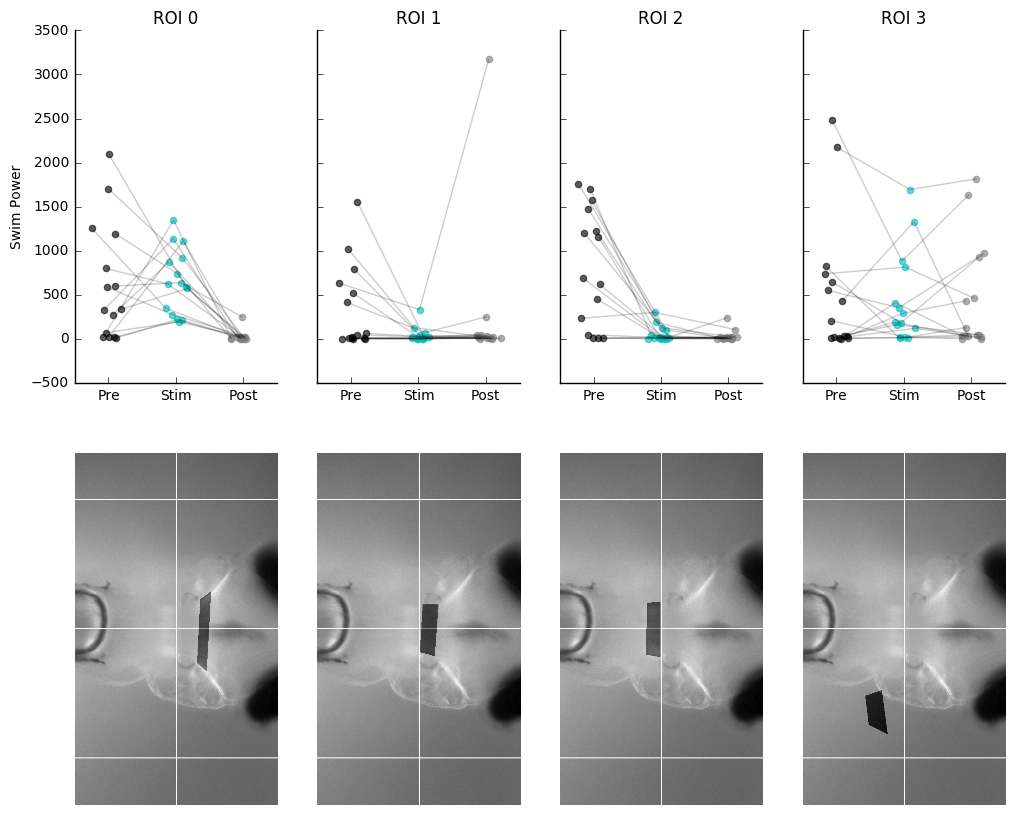

In [11]:
std = .1
fig, axs = plt.subplots(ncols=len(cond_swim_power),nrows=2, figsize=(3 * len(cond_swim_power), 10), sharey='row')
axs[0][0].set_ylabel('Swim Power')
colors = ['k','c','gray']

def thr_fun(v, thr=10):
    # function for thresholding swim power
    return v > thr

for ind_c, cond in enumerate(cond_swim_power):
    
    # truncate to minimum number of trials
    trunc = np.zeros([len(cond), min(map(len, cond))])
    for _, c in enumerate(cond):
        trunc[_] = c[:min(map(len, cond))]
    
    jitter = std * np.random.randn(*trunc.shape)    
    
    for ind_j, j in enumerate(jitter):
        j += ind_j
        
    cur_ax = axs[0][ind_c]
    cur_ax.plot(jitter, trunc, 'k', alpha = .2)    
    [cur_ax.scatter(jitter[ind_t][:len(vec)], vec, color = colors[ind_t], alpha = .6 ) for ind_t, vec in enumerate(trunc)];    
    
    cur_ax.set_xticks([0, 1, 2])
    cur_ax.set_xticklabels(['Pre', 'Stim', 'Post'])
    cur_ax.set_title('ROI {0}'.format(ind_c))
    axs_format(cur_ax)
    
    im_ax = axs[1][ind_c]
    im_ax.imshow(im_roi[ind_c][:,:,0] * 70 + im_anat, cmap='gray')
    im_ax.axis('off')

plt.savefig(proc_dir + exp_name + '_trial_summary.pdf')

## Plot each trial

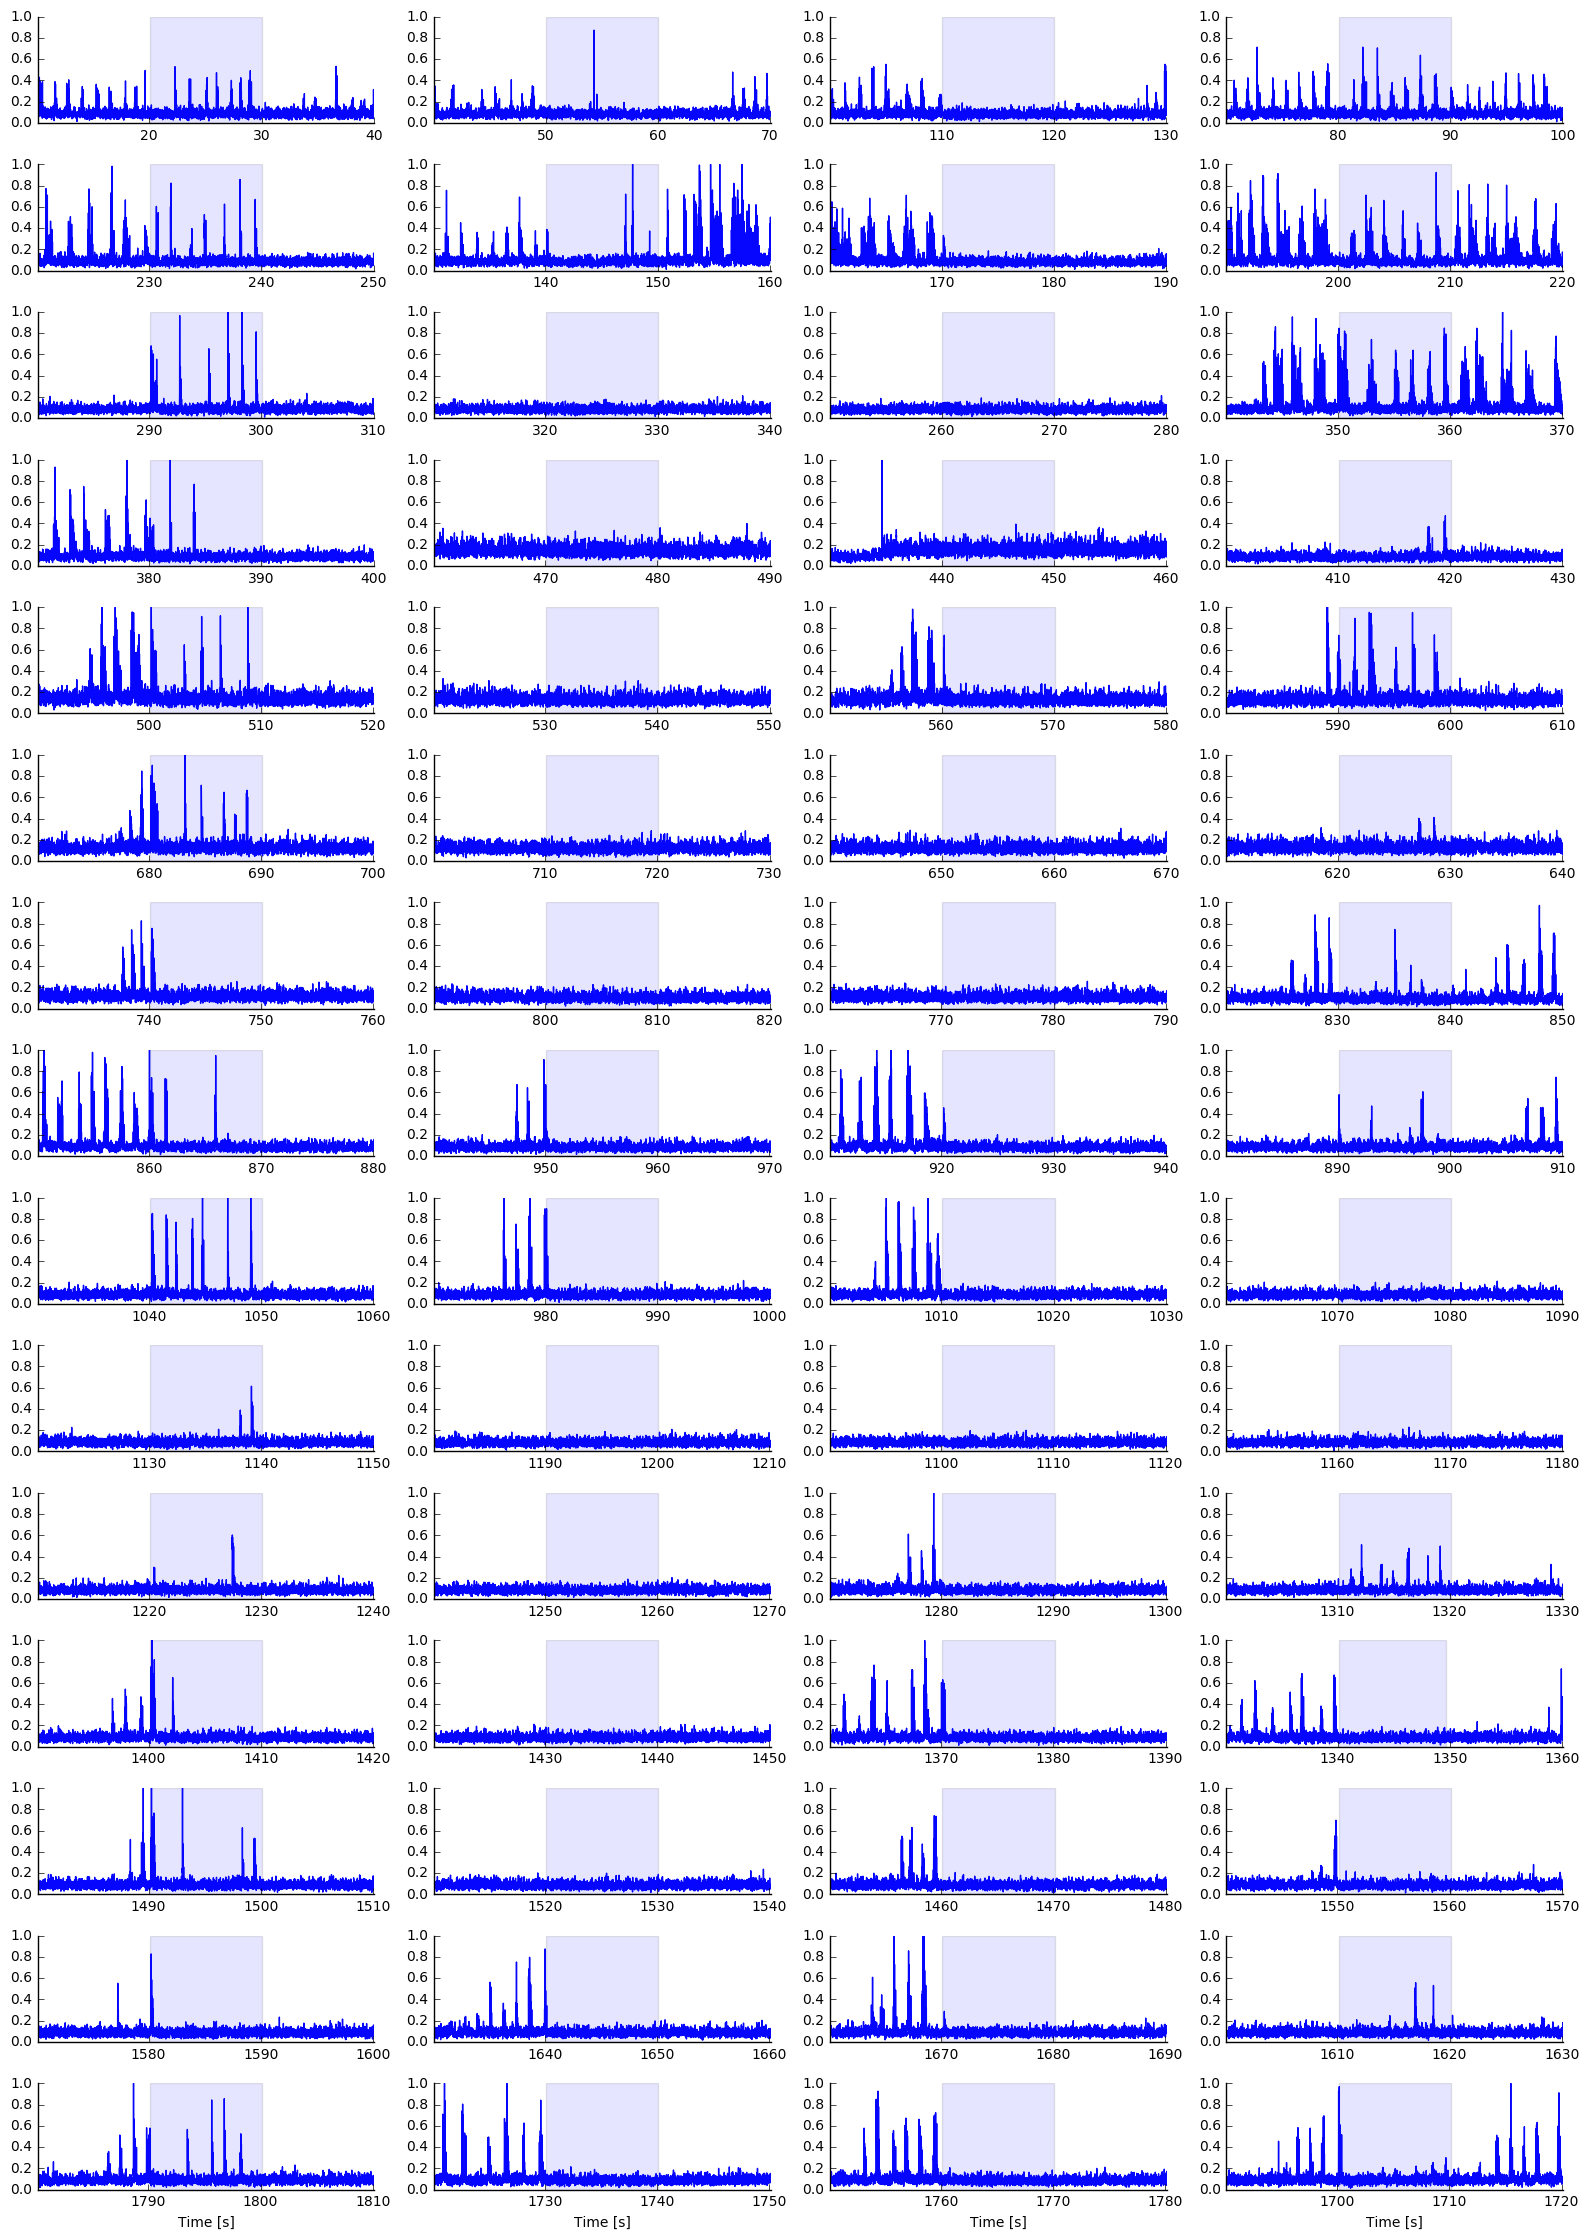

In [16]:
wind_ep = np.arange(-stim_len*fs, (2 * stim_len)*fs).astype('int')
wind_t = wind_ep / fs
plot_inds = []
ts = prepare_swim(dat[0:2])
for cond in conds:
    onsets = rois[cond][0]
    inds = np.array([wind_ep + o for o in onsets])
    # check for inds that exceed the recording length
    inds = inds[inds[:,-1] < len(swims[0])]
    plot_inds.append(inds)

n_trials = max([len(p) for p in plot_inds])
fig, axs = plt.subplots(nrows=(n_trials), ncols = len(conds), sharey=False, figsize=(4 * len(conds), 1.5 * n_trials))

if len(conds) == 1:
    axs = [[ax] for ax in axs]
    
for ind_c, cond in enumerate(conds):
    for ind_t in range(min(n_trials, len(plot_inds[ind_c]))):
        
        plr = plot_inds[ind_c][ind_t]
        laser_on = np.where(dat[6][plr] > 1.0)[0]
        cur_ax = axs[ind_t][ind_c]
        cur_ts = ts[plr]
        cur_ax.plot(plr/fs, cur_ts, alpha=7)
        #cur_ax.plot(plr/fs, swim_scale * swim2_flt[plr], alpha=.7)
        cur_ax.set_xlim((plr[0] / fs, plr[-1]/fs))
        #cur_ax.set_ylim(0,1)
        
        collection_laser = collections.BrokenBarHCollection.span_where(
        plr/fs, ymin=0, ymax=1, where=dat[6][plr] > 1.0, facecolor='b', alpha=0.1)
        
        #axs[ind_t][ind_c].axvspan(plr[len(plr)//2] / fs, plr[len(plr)//2]/fs + stim_len, color='b', alpha = .1)
        cur_ax.add_collection(collection_laser)
        axs_format(cur_ax)
        cur_ax.set_xticks(axs[ind_t][ind_c].get_xticks()[::2][1:])
        cur_ax.set_ylim(ts.min(), ts.max())
    
    axs[-1][ind_c].set_xlabel('Time [s]')    
plt.tight_layout()

plt.savefig(proc_dir + exp_name + '_trials.pdf')

In [70]:
kw = 24001
kern_smth = np.exp(-5 * np.linspace(0, 1, kw))
# pad kernel
pad = np.zeros(kern_smth.shape)
kern_smth = np.hstack([pad, kern_smth])
kern_smth /= kern_smth.sum()

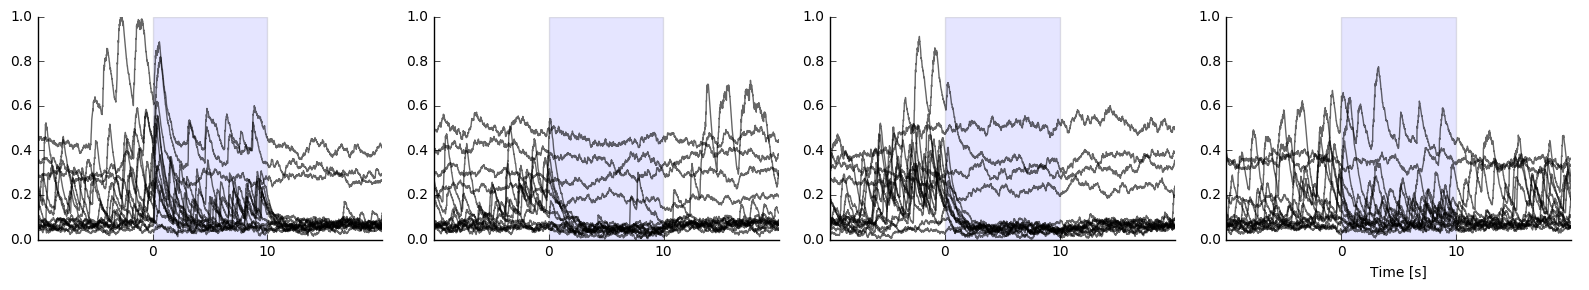

In [71]:
ts_smth = fftconvolve(ts - ts.mean(), kern_smth, 'same')
ts_smth -= ts_smth.min()
ts_smth /= ts_smth.max()
wind_ep = np.arange(-stim_len*fs, (2 * stim_len)*fs).astype('int')
wind_t = wind_ep / fs
plot_inds = []

for cond in conds:
    onsets = rois[cond][0]
    inds = np.array([wind_ep + o for o in onsets])
    # check for inds that exceed the recording length
    inds = inds[inds[:,-1] < len(swims[0])]
    plot_inds.append(inds)

n_trials = max([len(p) for p in plot_inds])
fig, axs = plt.subplots(nrows=1, ncols = len(conds), sharey=False, figsize=(4 * len(conds), 3))

if len(conds) == 1:
    axs = [[ax] for ax in axs]
    
for ind_c, cond in enumerate(conds):
    cur_ax = axs[ind_c]
    collection_laser = collections.BrokenBarHCollection.span_where(
        wind_ep / fs, ymin=0, ymax=1, where=dat[6][plr] > 1.0, facecolor='b', alpha=0.1)
                
    cur_ax.add_collection(collection_laser)
    
    for ind_t in range(min(n_trials, len(plot_inds[ind_c]))):
        
        plr = plot_inds[ind_c][ind_t]
        laser_on = np.where(dat[6][plr] > 1.0)[0]        
        cur_ts = ts_smth[plr]
        cur_ax.plot(wind_ep / fs, cur_ts, alpha=.6, color='k')
        #cur_ax.plot(plr/fs, swim_scale * swim2_flt[plr], alpha=.7)
        #cur_ax.set_xlim((plr[0] / fs, plr[-1]/fs))    
    
    axs[-1].set_xlabel('Time [s]')    
    cur_ax.set_xticks(cur_ax.get_xticks()[::2][1:])
    cur_ax.set_xlim(wind_ep[0] / fs, wind_ep[-1] / fs)
    cur_ax.set_ylim(ts_smth.min(), ts_smth.max())    
    axs_format(cur_ax)
    
plt.tight_layout()

#plt.savefig(proc_dir + exp_name + '_trials.pdf')

In [ ]:
# outdated code 
from scipy.signal import gaussian
from scipy.signal import fftconvolve
kw = 3000
kern_var = np.exp(-5 * np.linspace(0, 1, kw))
# pad kernel
pad = np.zeros(kern_var.shape)
kern_var = np.hstack([pad, kern_var])
kern_var /= kern_var.sum()

kern_mean = gaussian(26001, 2400)
kern_mean /= kern_mean.sum()

swim_flt = [ephys.windowed_variance(s, kern_mean=None, kern_var=None)[2] for s in swims]
ts = (swim_flt[0] + swim_flt[1])
ts = ts.clip(max = np.percentile(ts, 99.99))
ts -= ts.min()
ts /= ts.max()
th = estimate_threshold(ts)